---
title: Notes
---

# Update

## 02/16/2024

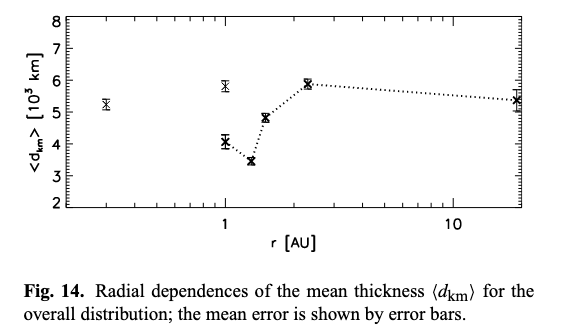

-   Normalization of the daily rates to 400 km/s ?

![](images/paste-2.png)

![](images/paste-1.png)

![](images/paste-3.png)

## Solar Wind Model

Sadly, JUNO does not provide plasma data during the cruise phase, so to estimate the plasma state we will use MHD model.

We are using [Michigan Solar WInd Model 2D (MSWIM2D)](http://csem.engin.umich.edu/MSWIM2D/), which models the solar wind propagation in 2D using the BATSRUS MHD solver. @keeblerMSWIM2DTwodimensionalOuter2022

Some key points about the model

-   Representing the solar wind in the ecliptic plane from 1 to 75 AU
-   2D MHD model, using the BATSRUS MHD solver
-   Inclusion of neutral hydrogen (important for the outer heliosphere)
-   Inner boundary is filled by time-shifting in situ data from multiple spacecraft

For model validation part, please see [JUNO Model Report](notebooks/20_model.ipynb).

# Properties

::: {#fig-ocr layout-ncol="2"}
![](figures/ocr/ocr_time_cleaned)

![](figures/ocr/ocr_time_N2_cleaned)

![](figures/ocr/ocr_r_cleaned)

![](figures/ocr/ocr_r_N2_cleaned)

Occurrence rates with time and radial distance
:::


::: {.column-page layout-ncol="2"}
![MN thickness](figures/thickness/thickness_mn_dist)

![MN current](figures/current/current_mn_dist)

![MN normalized thickness](figures/thickness/thickness_mn_N1_dist)

![MN normalized current](figures/current/current_mn_N1_dist)

Thickness and current density distribution
:::

# TODOs

Science part

-   Analysis
    -   [ ] Contribution of discontinuities to the power spectrum
    -   [ ] Check Datagap
    -   [ ] Check `ARTEMIS-B` data in different states (solar wind, magnetosheath, magnetotail, moon wake)
    -   [ ] Distribution of \|B\| over radius
    -   [ ] JUNO from 2012-09\~2012-10 lack of IDS and extreme large thickness
    -   [ ] Wind data
    -   [ ] Add error bar
    -   [ ] Validate the effects of calibrate candidate duration
    -   [ ] Validate model density with `Voyager`
-   Identifaction
    -   [ ] Ensemble forest?
    -   [ ] Smoothing is important?
    -   [ ] Check change point algorithm
-   Visualize data gaps
-   Features
    -   [ ] Thickness in N direction
    -   [ ] Use high resolution data for feature extraction
-   Compare with other methods of identifying IDs
    -   [ ] Verify with other methods of identifying IDs
-   [x] Incorporate solar wind propagation model
    -   [x] Verify with solar wind propagation model
        -   [x] Coordinate transformation

In [13]:
#| label: tbl-missions
#| tbl-cap: Missions info
import yaml
import polars as pl
from functools import reduce
from IPython.display import Markdown
from tabulate import tabulate

with open("data/info.yml", "r") as file:
    data = yaml.safe_load(file)


# Recursive function to find magnetometers
def find_instrument(instruments, ins_type):
    instrument = {}
    for key, value in instruments.items():
        if value.get("type") == ins_type:
            instrument = value
        elif "instruments" in value:
            instrument = find_instrument(value["instruments"], ins_type)
    return instrument


def parse_yaml(data, info, ins_type=None):
    rows = []

    for mission, details in data["missions"].items():
        if ins_type is None:
            rows.append([mission, details.get(info)])
            continue
        instruments = details.get("instruments", {})
        instrument = find_instrument(instruments, ins_type)
        rows.append([mission, instrument.get(info)])

    return pl.DataFrame(rows, schema=["Mission", info])


# Define the merge function
def merge_dfs(left, right, on="Mission", how="outer"):
    return left.join(right, on=on, how=how)


# Parse and display the table
df_mag = parse_yaml(data, "time_resolutions", "magnetometer").rename(
    {"time_resolutions": "$\delta t_B$"}
)
df_plasma = parse_yaml(data, "time_resolutions", "plasma").rename(
    {"time_resolutions": "$\delta t_{plasma}$"}
)
df_r = parse_yaml(data, "radial_coverage").rename({"radial_coverage": "Radial coverage"})
df_time = parse_yaml(data, "launch_date").rename({"launch_date": "Launch date"})
df_link = parse_yaml(data, "website")

df_list = [df_mag, df_plasma, df_r, df_time, df_link]  # Replace with your DataFrames

df_merged = reduce(merge_dfs, df_list)
# df = pd.merge(df1, df2, on='Mission')
Markdown(df_merged.to_pandas().to_markdown(index=False))

| Mission            | $\delta t_B$   | $\delta t_{plasma}$   | Radial coverage   | Launch date         | website                                                         |
|:-------------------|:---------------|:----------------------|:------------------|:--------------------|:----------------------------------------------------------------|
| Juno               | 1 Hz           |                       | 1 - 5.5 AU        | 2011-08-05 00:00:00 | ['[NASA](https://science.nasa.gov/mission/juno)']               |
| ARTEMIS            | 5 Hz, ...      |                       |                   | 2007-02-17 00:00:00 |                                                                 |
| STEREO-A           | 8 Hz           |                       |                   | 2006-10-26 00:00:00 |                                                                 |
| WIND               | 11 Hz          |                       |                   | 1994-11-01 00:00:00 | ['[NASA](https://science.nasa.gov/mission/wind/)']              |
| Solar Orbiter      |                |                       | 0.28 - 0.9 AU     | 2020-02-10 00:00:00 | ['[ESA](https://sci.esa.int/web/solar-orbiter)']                |
| Parker Solar Probe |                |                       | 0.05 - 1 AU       | 2018-08-12 00:00:00 | ['[NASA](https://science.nasa.gov/mission/parker-solar-probe)'] |